In [ ]:
!git clone https://github.com/r1cemilk/ZPD_Data_7.git

Cloning into 'ZPD_Data_7'...
remote: Enumerating objects: 14290, done.
remote: Total 14290 (delta 0), reused 0 (delta 0), pack-reused 14290
Receiving objects: 100% (14290/14290), 901.68 MiB | 24.61 MiB/s, done.
Updating files: 100% (14293/14293), done.


In [ ]:
!ls ZPD_Data_7/

Screenshots  test.csv


In [ ]:
!pip3 install imgaug

In [ ]:
import os
import cv2
import ntpath
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from imgaug import augmenters as iaa

In [ ]:
datadir = 'ZPD_Data_7'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'test.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-5-e27acebdb697>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  /big_drive/ZPD_Data_7/Screenshots/center_20240224_231517341.png   
1  /big_drive/ZPD_Data_7/Screenshots/center_20240224_231517491.png   
2  /big_drive/ZPD_Data_7/Screenshots/center_20240224_231517636.png   
3  /big_drive/ZPD_Data_7/Screenshots/center_20240224_231517786.png   
4  /big_drive/ZPD_Data_7/Screenshots/center_20240224_231517935.png   

                                                            left  \
0  /big_drive/ZPD_Data_7/Screenshots/left_20240224_231517355.png   
1  /big_drive/ZPD_Data_7/Screenshots/left_20240224_231517498.png   
2  /big_drive/ZPD_Data_7/Screenshots/left_20240224_231517642.png   
3  /big_drive/ZPD_Data_7/Screenshots/left_20240224_231517793.png   
4  /big_drive/ZPD_Data_7/Screenshots/left_20240224_231517940.png   

                                                            right  steering  \
0  /big_drive/ZPD_Data_7/Screenshots/right_20240224_231517361.png  0.000000   
1  /big_drive/ZPD_Data_7/Screenshots/right_20240224_231517504.png  0.000000   
2  /big_drive/ZPD_Data_7/Screenshots/right_20240224_231517648.png -0.171665   
3  /big_drive/ZPD_Data_7/Screenshots/right_20240224_231517798.png  0.000000   
4  /big_drive/ZPD_Data_7/Screenshots/right_20240224_231517946.png  0.000000   

   throttle  reverse     speed  
0  0.0       0        9.900001  
1  0.0       0        9.800000  
2  0.0       0        9.800000  
3  0.0       0        9.700000  
4  0.0       0        9.700000

In [ ]:
# returning the end of path
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                         left  \
0  center_20240224_231517341.png  left_20240224_231517355.png   
1  center_20240224_231517491.png  left_20240224_231517498.png   
2  center_20240224_231517636.png  left_20240224_231517642.png   
3  center_20240224_231517786.png  left_20240224_231517793.png   
4  center_20240224_231517935.png  left_20240224_231517940.png   

                          right  steering  throttle  reverse     speed  
0  right_20240224_231517361.png  0.000000  0.0       0        9.900001  
1  right_20240224_231517504.png  0.000000  0.0       0        9.800000  
2  right_20240224_231517648.png -0.171665  0.0       0        9.800000  
3  right_20240224_231517798.png  0.000000  0.0       0        9.700000  
4  right_20240224_231517946.png  0.000000  0.0       0        9.700000

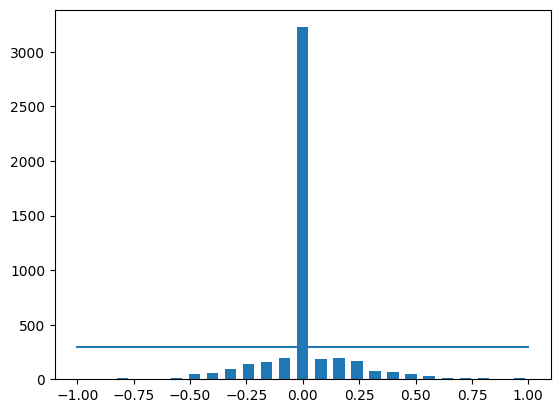

In [ ]:
#need an odd number to get centered distribution
num_bins = 25
samples_per_bin=300

# NOTE: doing this because there's a big data imbalance between driving straight and turning


hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5

plt.bar(center, hist, width=0.05)
#plotting a line
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed:  2924
remaining:  1840


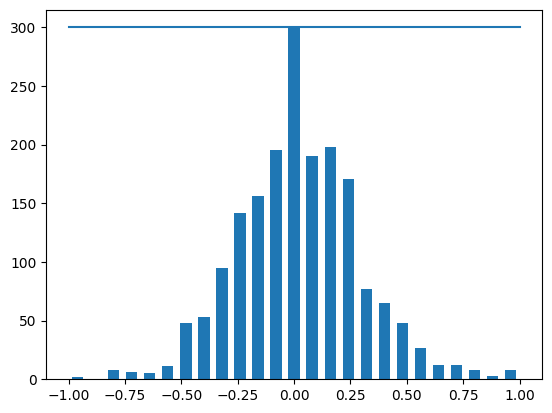

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
       list_.append(i)

  list_ = shuffle(list_)
  list_ =  list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_image_steering(datadir, df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    #iloc performs a specific row selection based on specified index
    indexed_data=data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path)
  steering=np.asarray(steering)
  return image_paths,steering

# passing the image dir and data
image_paths, steerings = load_image_steering(datadir + '/Screenshots', data)

In [ ]:
# splits into random test and train subsets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [ ]:
print('Training samples: ', len(X_train))
print('Validation samples: ', len(X_valid))

Training samples:  1472
Validation samples:  368


Text(0.5, 1.0, 'Validation set')

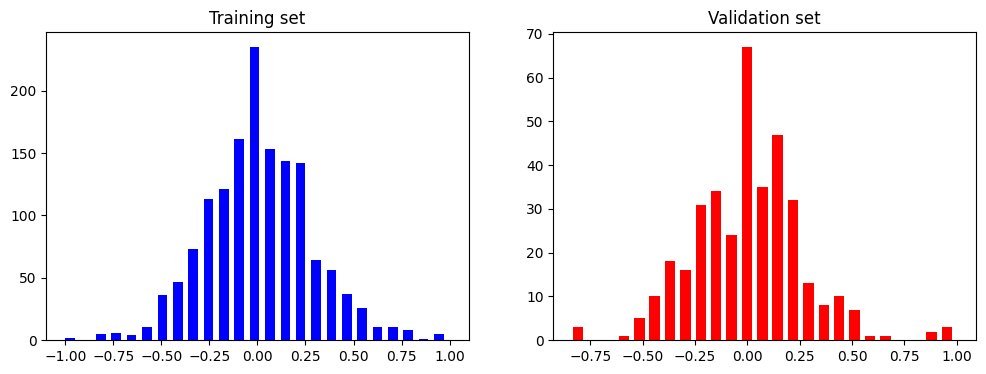

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')


axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [ ]:
def image_random_brightness(image):
  #multiplies pixel intensity
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = image_random_brightness(image)
  #removed flip because it might mess up the car with deciding in which lane to stay in.

  # if np.random.rand() < 0.5:
  #   image = img_random_flip(image, steering_angle)
  return image, steering_angle

ZPD_Data_7/Screenshots/center_20240224_232524620.png
ZPD_Data_7/Screenshots/center_20240224_232502429.png
ZPD_Data_7/Screenshots/center_20240224_232629594.png
ZPD_Data_7/Screenshots/center_20240224_232040584.png
ZPD_Data_7/Screenshots/center_20240224_232226707.png
ZPD_Data_7/Screenshots/center_20240224_232256703.png
ZPD_Data_7/Screenshots/center_20240224_231802780.png
ZPD_Data_7/Screenshots/center_20240224_231722745.png
ZPD_Data_7/Screenshots/center_20240224_231950210.png
ZPD_Data_7/Screenshots/center_20240224_231705633.png


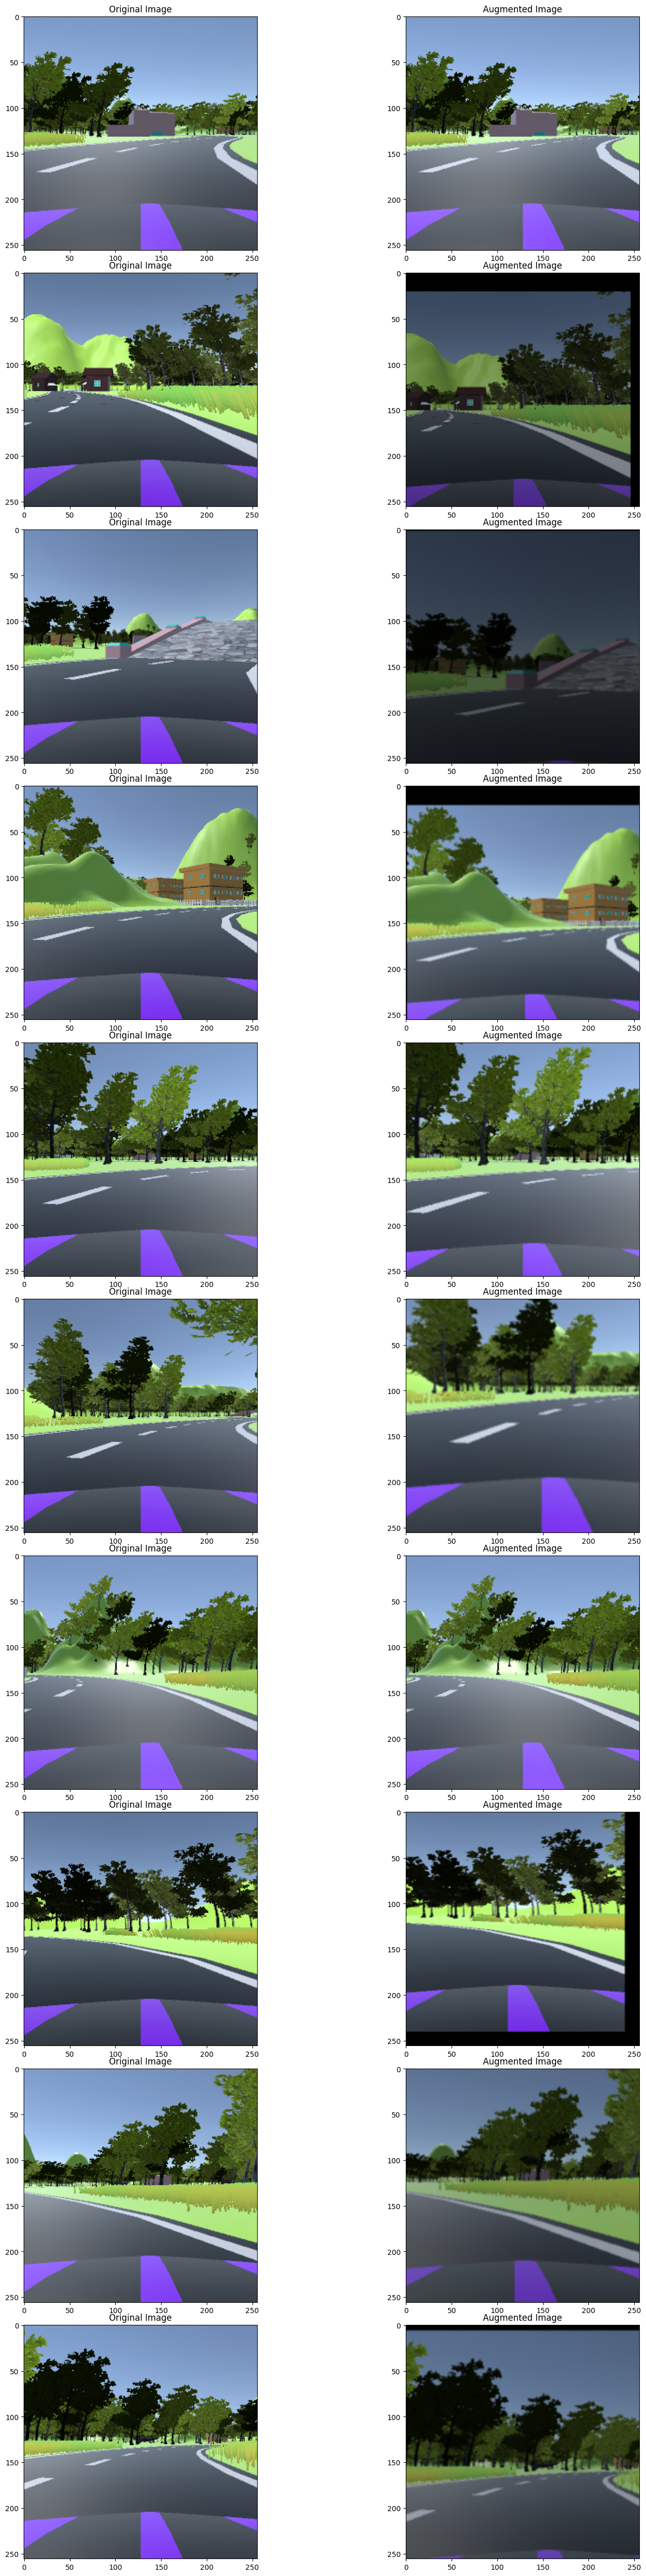

In [ ]:
ncol = 2
nrow = 10

fig, axis = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  print(image_paths[randnum])
  random_steering=steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering_angle = random_augment(random_image,random_steering)

  axis[i][0].imshow(original_image)
  axis[i][0].set_title('Original Image')

  axis[i][1].imshow(augmented_image)
  axis[i][1].set_title('Augmented Image')

In [ ]:
def img_preprocess(img):
    # img = mpimg.imread(img);
    img = img[125:200, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    # img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

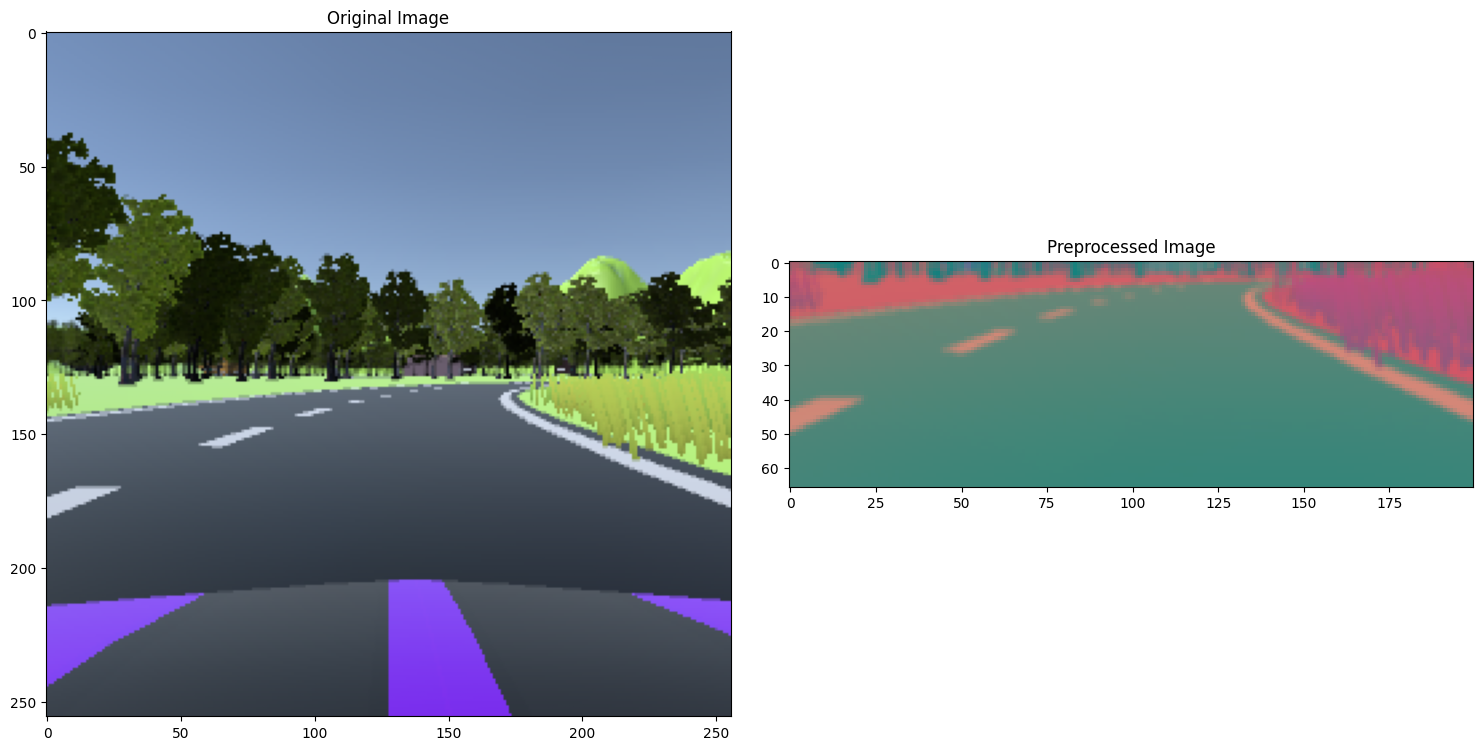

In [ ]:
image = image_paths[200]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
#prevent overlapping
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_angle, batch_size, isTraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if isTraining:
        im, steering = random_augment(image_paths[random_index], steering_angle[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

In [ ]:

#taken from nvidia article
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, (5,5),strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, (5,5),strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, (3,3), activation='elu'))
  model.add(Convolution2D(64, (3,3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(lr=0.0001)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, isTraining=1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)

<ipython-input-28-1dd5334955d2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, isTraining=1),


Epoch 1/10
300/300 [==============================] - 480s 2s/step - loss: 0.0806 - val_loss: 0.0293
Epoch 2/10
300/300 [==============================] - 427s 1s/step - loss: 0.0389 - val_loss: 0.0291
Epoch 3/10
300/300 [==============================] - 481s 2s/step - loss: 0.0359 - val_loss: 0.0286
Epoch 4/10
300/300 [==============================] - 479s 2s/step - loss: 0.0338 - val_loss: 0.0294
Epoch 5/10
300/300 [==============================] - 477s 2s/step - loss: 0.0333 - val_loss: 0.0260
Epoch 6/10
300/300 [==============================] - 458s 2s/step - loss: 0.0324 - val_loss: 0.0283
Epoch 7/10
300/300 [==============================] - 455s 2s/step - loss: 0.0316 - val_loss: 0.0305
Epoch 8/10
300/300 [==============================] - 465s 2s/step - loss: 0.0314 - val_loss: 0.0263
Epoch 9/10
300/300 [==============================] - 455s 2s/step - loss: 0.0314 - val_loss: 0.0296
Epoch 10/10
300/300 [==============================] - 404s 1s/step - loss: 0.0298 - val_lo

Text(0.5, 0, 'Epoch')

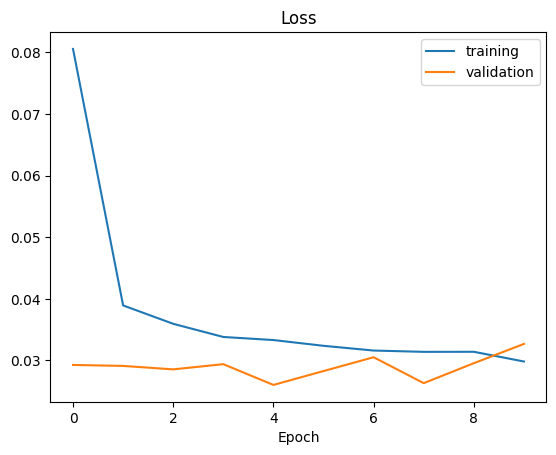

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save("BehaviouralCloning_6.h5")

from google.colab import files
files.download('BehaviouralCloning_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>